Material produzido no estudo de análise de dados aplicados as finanças

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":9})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Define the date range
start_date = date.today() - timedelta(days=365)
end_date = date.today()

# List of stocks and corresponding company names
stocks = ['POMO4.SA', 'WEGE3.SA', 'PETR4.SA', 'BTLG11.SA', 'B3SA3.SA']
company_names = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa"]

# Initialize a dictionary to store different types of price data
price_data_dict = {key: [] for key in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']}

def merge_dataframes(data_list):
    """Merge a list of DataFrames on the 'Date' column."""
    if not data_list:
        return None
    
    merged_df = data_list[0]
    if isinstance(merged_df.columns, pd.MultiIndex):
        merged_df.columns = merged_df.columns.get_level_values(0)

    for df in data_list[1:]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        merged_df = pd.merge(merged_df, df, on='Date', how='outer')
    
    return merged_df

def download_and_prepare_stock_data(stock_symbol, company_name):
    """Download stock data and prepare it for processing."""
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date).reset_index()
    
    for price_type in price_data_dict:
        if price_type in stock_data.columns:
            price_df = stock_data[['Date', price_type]].rename(columns={price_type: company_name})
            price_data_dict[price_type].append(price_df)

# Download and prepare data for each stock
for stock_symbol, company_name in zip(stocks, company_names):
    download_and_prepare_stock_data(stock_symbol, company_name)

# Combine all price type dataframes
df_adj_close = merge_dataframes(price_data_dict['Adj Close'])
df_adj_close['Carteira'] = df_adj_close.iloc[:, 1:5].sum(axis=1)
df_close = merge_dataframes(price_data_dict['Close'])
df_high = merge_dataframes(price_data_dict['High'])
df_low = merge_dataframes(price_data_dict['Low'])
df_open = merge_dataframes(price_data_dict['Open'])
df_volume = merge_dataframes(price_data_dict['Volume'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df_adj_close.describe().round(3)

Price,Marcopolo,Weg,Petrobras,BTG logística,Bovespa,Carteira
count,252.000,252.000,252.000,252.000,252.000,252.000
mean,6.947,42.251,35.319,97.137,11.785,181.654
std,0.790,8.158,2.337,2.573,1.093,11.689
min,5.336,31.818,29.440,90.736,9.913,158.454
25%,6.416,35.965,33.814,95.859,10.796,173.356
50%,6.832,38.538,35.880,97.219,11.756,178.797
75%,7.336,51.865,37.061,99.002,12.577,194.558
max,9.040,57.190,39.600,101.605,14.345,201.863


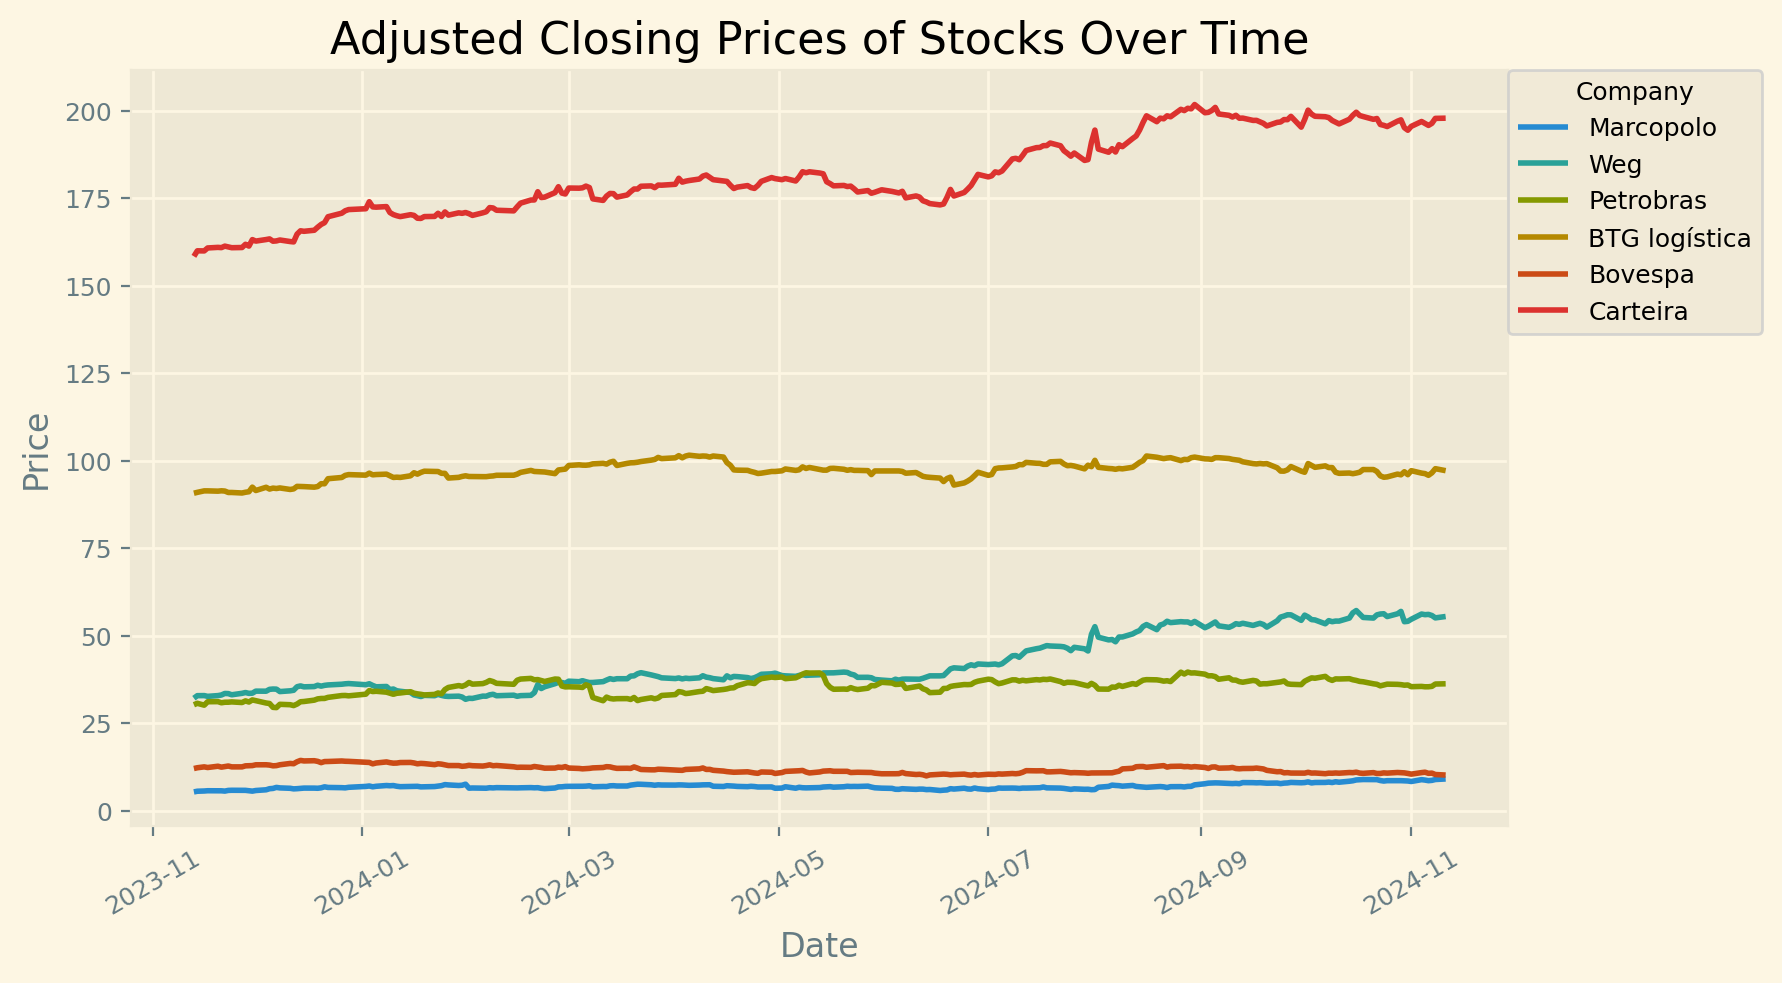

In [5]:
def plot_adjusted_closing_prices(melted_df, title='Adjusted Closing Prices of Stocks Over Time', figsize=(9, 5)):
    """
    Function to plot adjusted closing prices of stocks over time for a given melted DataFrame.
    
    Parameters:
    - melted_df (pd.DataFrame): The melted DataFrame containing 'Date', 'Company', and 'Price' columns.
    - title (str): The title of the plot.
    - figsize (tuple): The size of the figure (width, height).
    """
    # Check if the DataFrame contains the required columns
    required_columns = {'Date', 'Company', 'Price'}
    if not required_columns.issubset(melted_df.columns):
        raise ValueError(f"The DataFrame must contain the columns: {required_columns}")

    # Convert 'Date' column to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(melted_df['Date']):
        melted_df['Date'] = pd.to_datetime(melted_df['Date'])

    # Set the figure size
    plt.figure(figsize=figsize)

    # Create a line plot using seaborn for better aesthetics
    sns.lineplot(data=melted_df, x='Date', y='Price', hue='Company')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Show legend outside the plot
    plt.legend(title='Company', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

    # Add grid, rotate x-axis labels, and adjust layout
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
df_adj_close_melted = pd.melt(df_adj_close, id_vars=['Date'], var_name='Company', value_name='Price')
plot_adjusted_closing_prices(df_adj_close_melted)

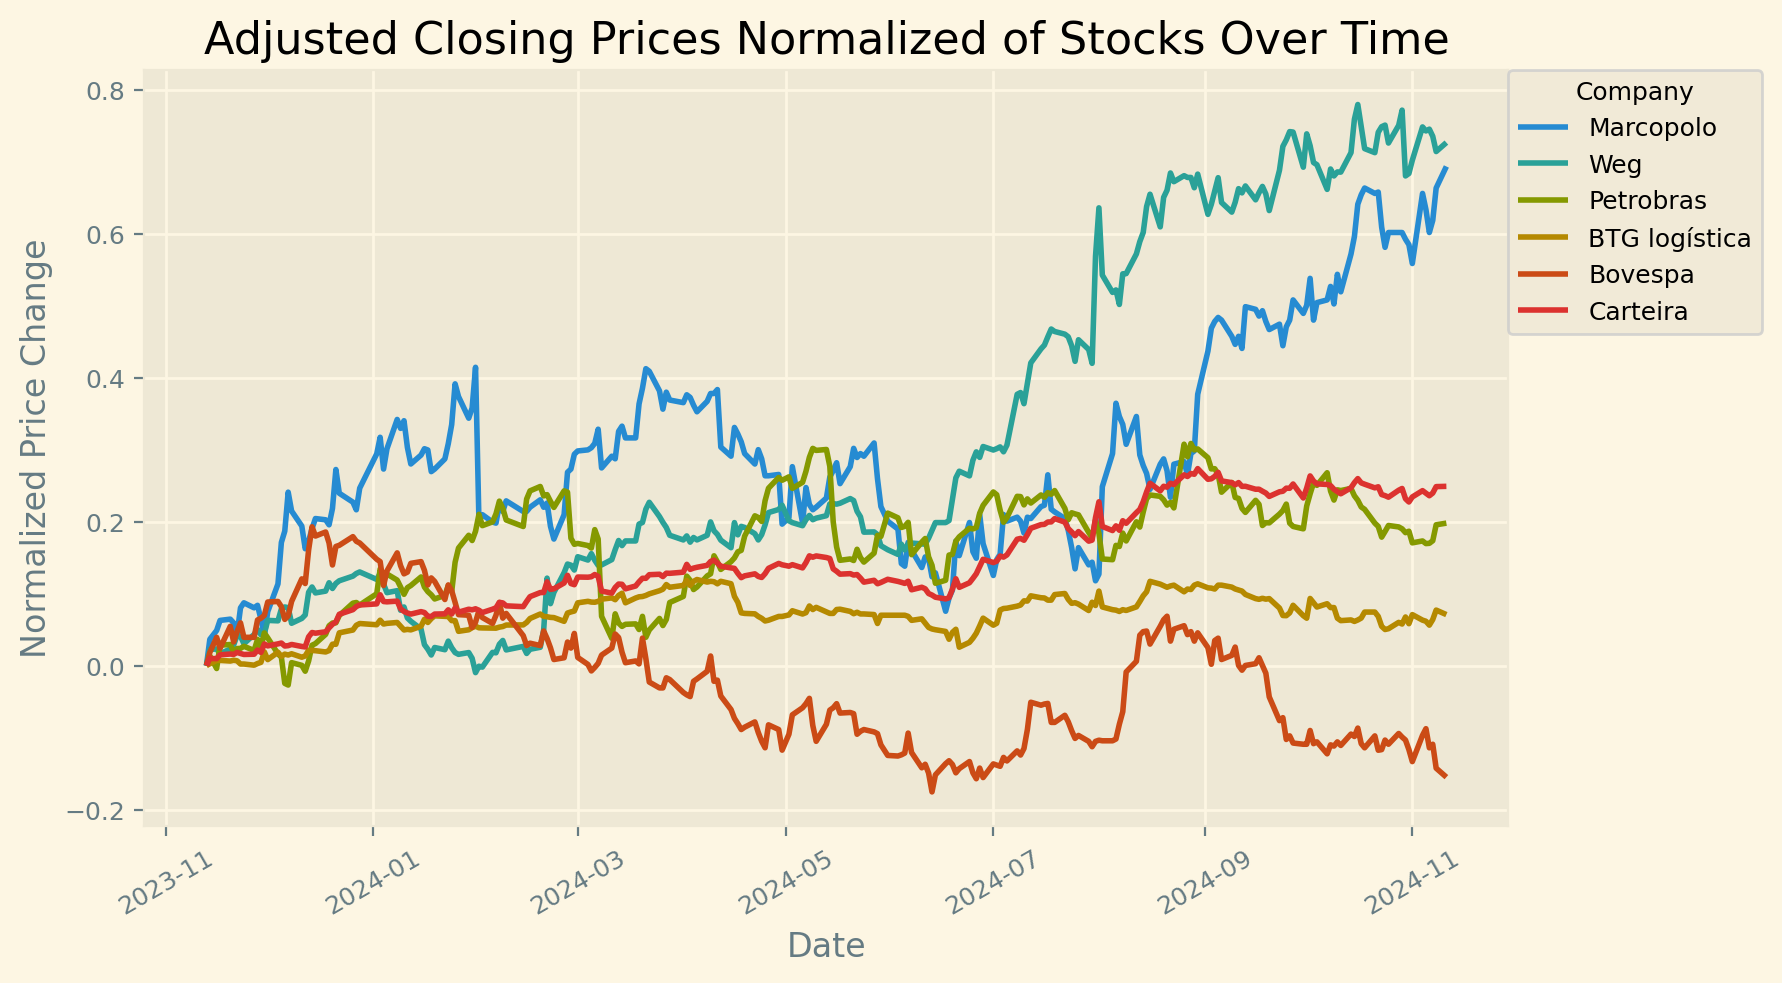

In [6]:
def plot_adjusted_closing_prices_normalized(melted_df, title='Adjusted Closing Prices Normalized of Stocks Over Time', figsize=(9, 5)):
    """
    Function to plot normalized adjusted closing prices of stocks over time for a given melted DataFrame.
    
    Parameters:
    - melted_df (pd.DataFrame): The melted DataFrame containing 'Date', 'Company', and 'Price' columns.
    - title (str): The title of the plot.
    - figsize (tuple): The size of the figure (width, height).
    """
    # Check if the DataFrame contains the required columns
    required_columns = {'Date', 'Company', 'Price'}
    if not required_columns.issubset(melted_df.columns):
        raise ValueError(f"The DataFrame must contain the columns: {required_columns}")

    # Convert 'Date' column to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(melted_df['Date']):
        melted_df['Date'] = pd.to_datetime(melted_df['Date'])

    # Set the figure size
    plt.figure(figsize=figsize)

    # Create a line plot using seaborn for better aesthetics
    sns.lineplot(data=melted_df, x='Date', y='Price', hue='Company')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Normalized Price Change')

    # Show legend outside the plot
    plt.legend(title='Company', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

    # Add grid, rotate x-axis labels, and adjust layout
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Normalize the data by company
df_adj_close_normalized = df_adj_close.copy()
for column in df_adj_close_normalized.columns[1:]:
    df_adj_close_normalized[column] = (df_adj_close_normalized[column] / df_adj_close_normalized[column].iloc[0]) - 1

# Melt the normalized DataFrame
df_adj_close_melted_normalized = pd.melt(df_adj_close_normalized, id_vars=['Date'], var_name='Company', value_name='Price')

# Plot the normalized data
plot_adjusted_closing_prices_normalized(df_adj_close_melted_normalized)

## Médias Móveis


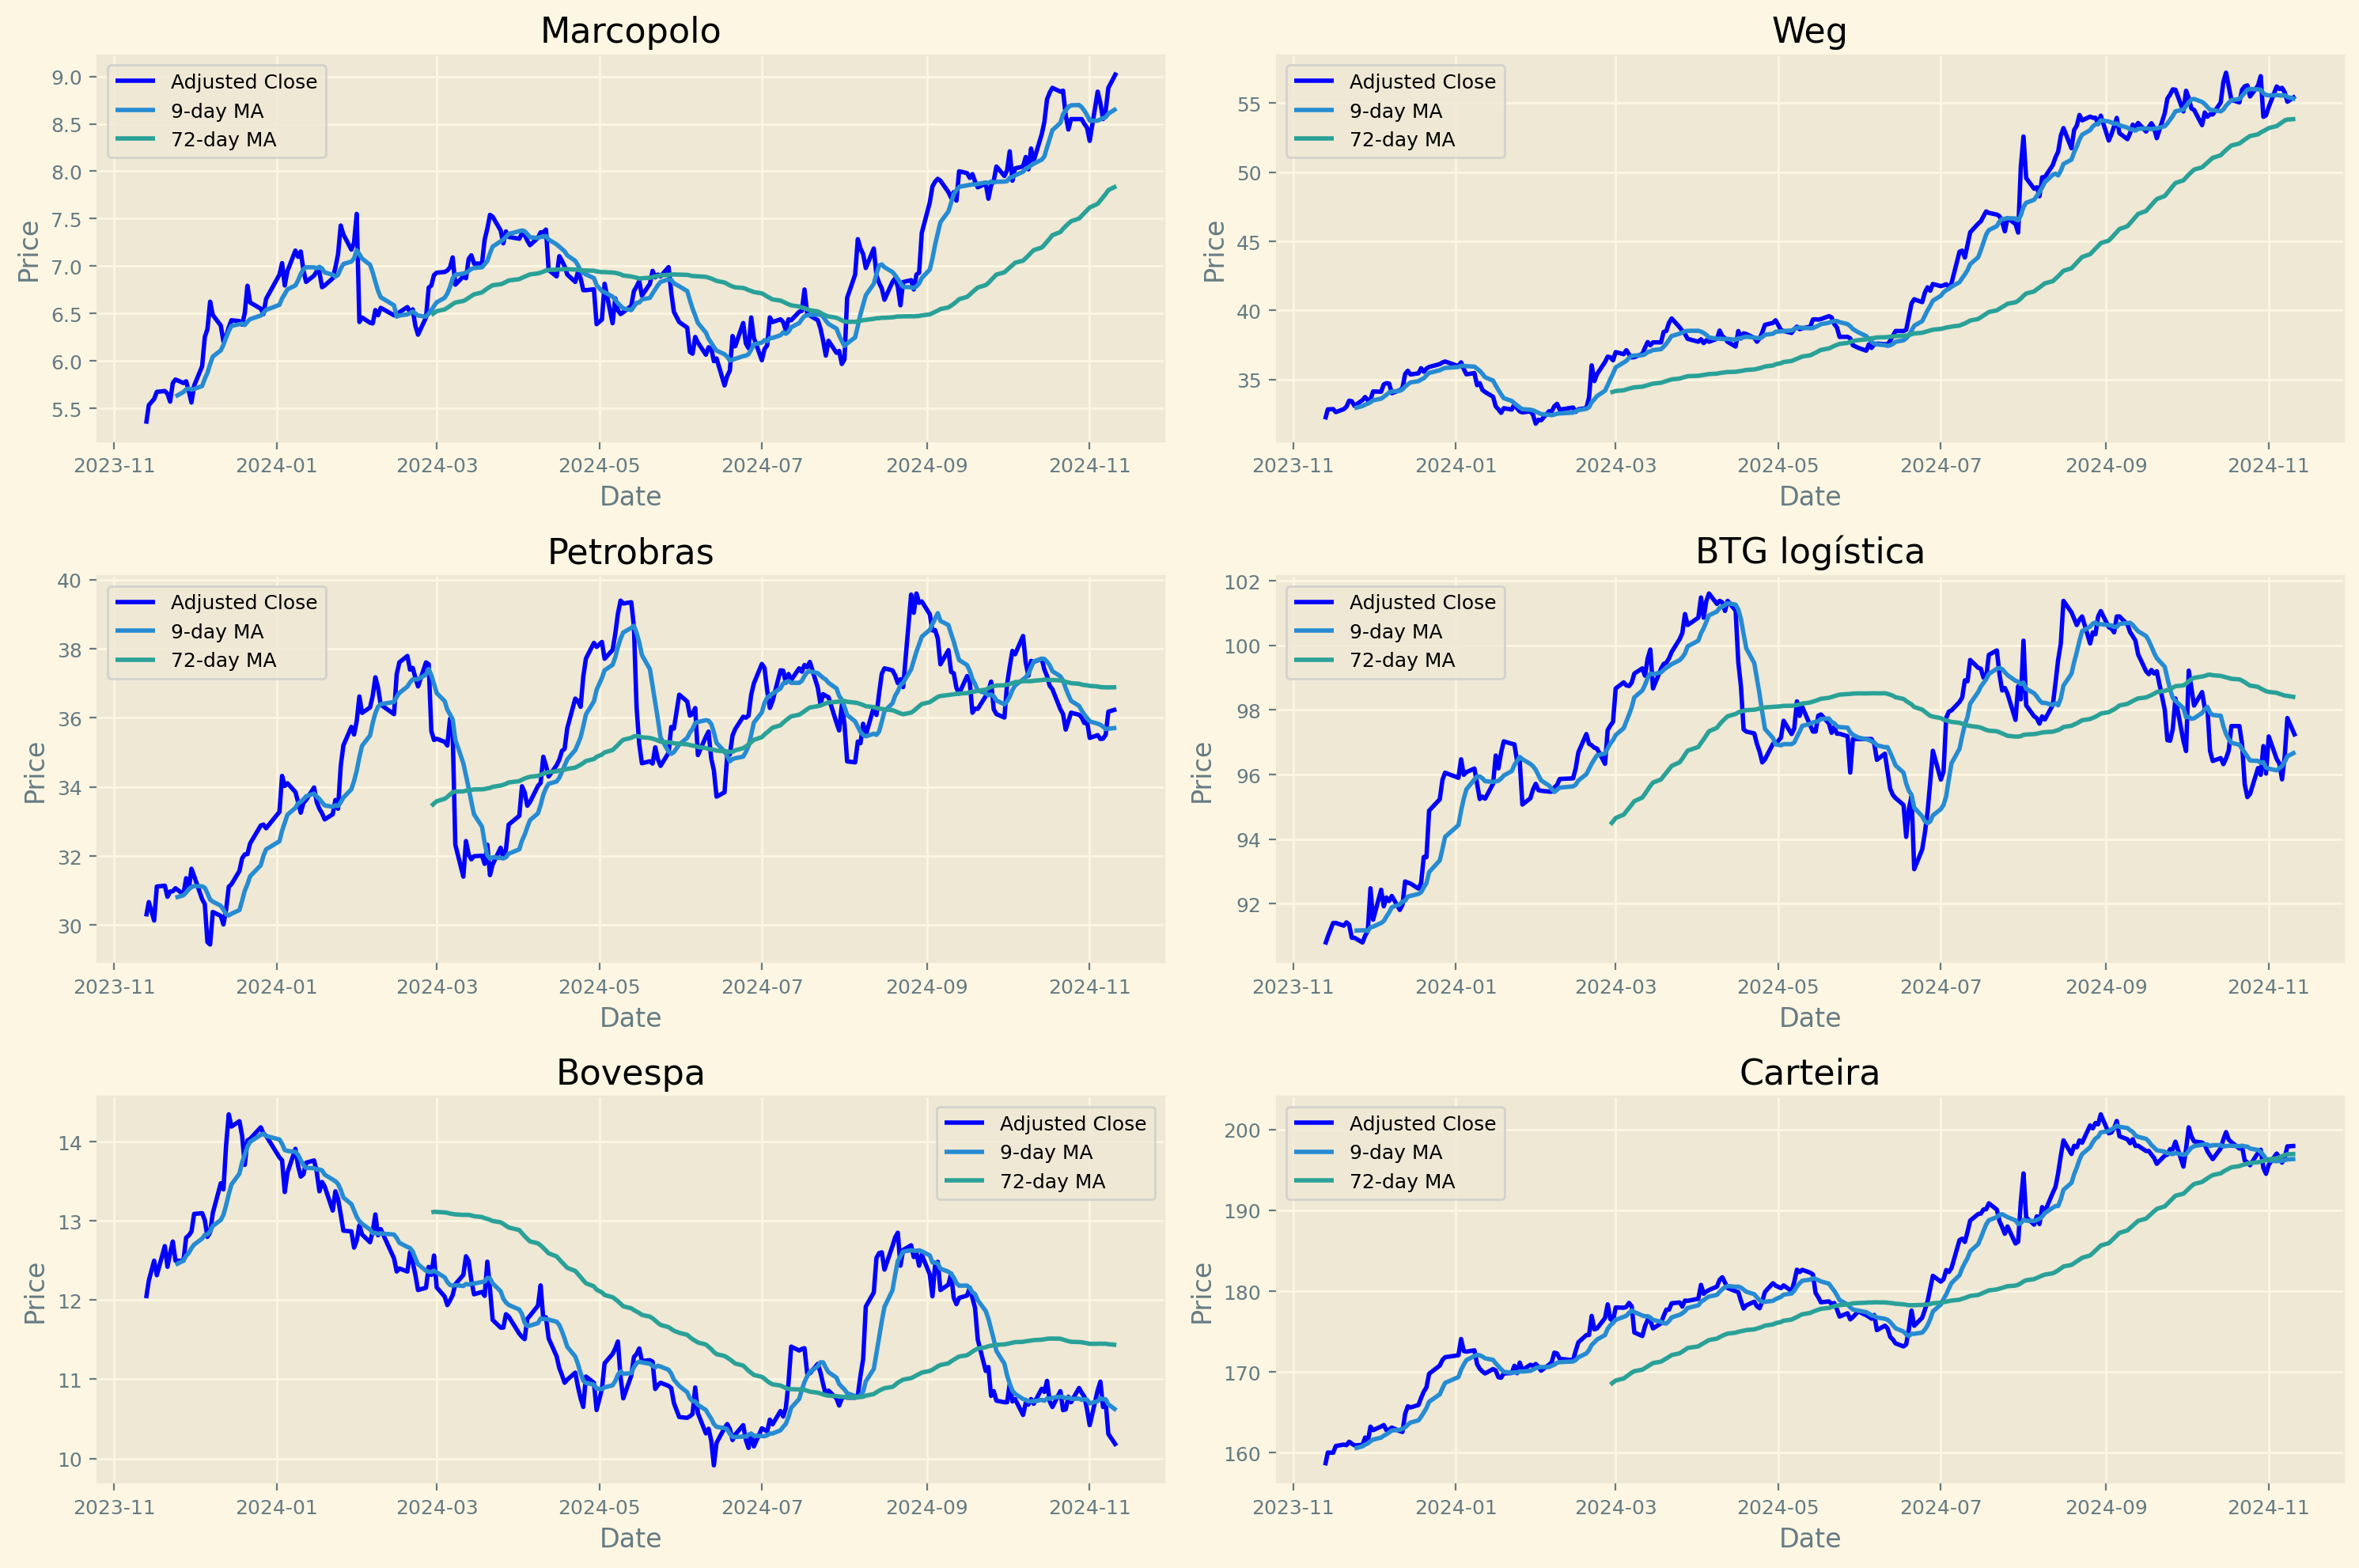

In [7]:
def calculate_and_plot_moving_averages(df_melted, company_names, ma_days=[9, 72], figsize=(15, 10)):
    """
    Function to calculate moving averages and plot them along with Adjusted Close prices.

    Parameters:
    - df_melted (pd.DataFrame): Melted DataFrame containing 'Date', 'Company', and 'Price'.
    - company_names (list): List of company names to plot.
    - ma_days (list): List of moving average periods.
    - figsize (tuple): Size of the figure (width, height).
    """
    # Verificar se as colunas necessárias estão presentes
    required_columns = {'Date', 'Company', 'Price'}
    if not required_columns.issubset(df_melted.columns):
        raise ValueError(f"O DataFrame deve conter as colunas: {required_columns}")

    # Adicionar colunas de médias móveis para cada empresa e período de média móvel
    for ma in ma_days:
        for company in company_names:
            # Filtrar dados para a empresa específica
            company_data = df_melted[df_melted['Company'] == company].copy()
            # Calcular a média móvel
            company_data[f"MA for {ma} days"] = company_data['Price'].rolling(ma).mean()
            # Mesclar a média móvel de volta ao DataFrame original
            df_melted.loc[df_melted['Company'] == company, f"MA for {ma} days"] = company_data[f"MA for {ma} days"]

    # Configurar subplots dinamicamente
    num_companies = len(company_names)
    num_rows = (num_companies + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=figsize)
    axes = axes.flatten()  # Flatten para fácil iteração

    # Plotar Preço Ajustado e Médias Móveis para cada empresa
    for i, company in enumerate(company_names):
        ax = axes[i]  # Determinar posição do subplot
        # Filtrar dados para a empresa atual
        company_data = df_melted[df_melted['Company'] == company]
        # Plotar o preço ajustado
        ax.plot(company_data['Date'], company_data['Price'], label='Adjusted Close', color='blue')
        # Plotar cada média móvel
        for ma in ma_days:
            ax.plot(company_data['Date'], company_data[f"MA for {ma} days"], label=f"{ma}-day MA")
        # Customizar o gráfico
        ax.set_title(company)
        ax.set_ylabel('Price')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True)

    # Ajustar layout para evitar sobreposição
    fig.tight_layout()

    # Mostrar o gráfico
    plt.show()

company_names = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa", "Carteira"]
calculate_and_plot_moving_averages(df_adj_close_melted, company_names)

## Taxas de retornos

### Simples

In [8]:
# Função para calcular e imprimir o retorno simples
def calculate_simple_return(column, df):
    """
    Calculate and print the simple return for a specific column in a DataFrame.
    
    Parameters:
    - column (str): The column name for which the simple return is calculated.
    - df (pd.DataFrame): The DataFrame containing the stock prices.
    """
    initial_price = df[column].iloc[0]
    final_price = df[column].iloc[-1]
    simple_return = round((final_price - initial_price) / initial_price, 4)
    print(f'Empresa: {column}, Retorno Simples: {simple_return}')

# Verificar se as colunas especificadas existem no DataFrame
columns_to_check = df_adj_close.columns[1:7]
missing_columns = [col for col in columns_to_check if col not in df_adj_close.columns]

if missing_columns:
    print(f"As seguintes colunas estão ausentes no DataFrame: {missing_columns}")
else:
    # Aplicar a função para as colunas selecionadas
    for column in columns_to_check:
        calculate_simple_return(column, df_adj_close)

Empresa: Marcopolo, Retorno Simples: 0.694
Empresa: Weg, Retorno Simples: 0.7272
Empresa: Petrobras, Retorno Simples: 0.1982
Empresa: BTG logística, Retorno Simples: 0.071
Empresa: Bovespa, Retorno Simples: -0.155
Empresa: Carteira, Retorno Simples: 0.2493


### Retorno Diário

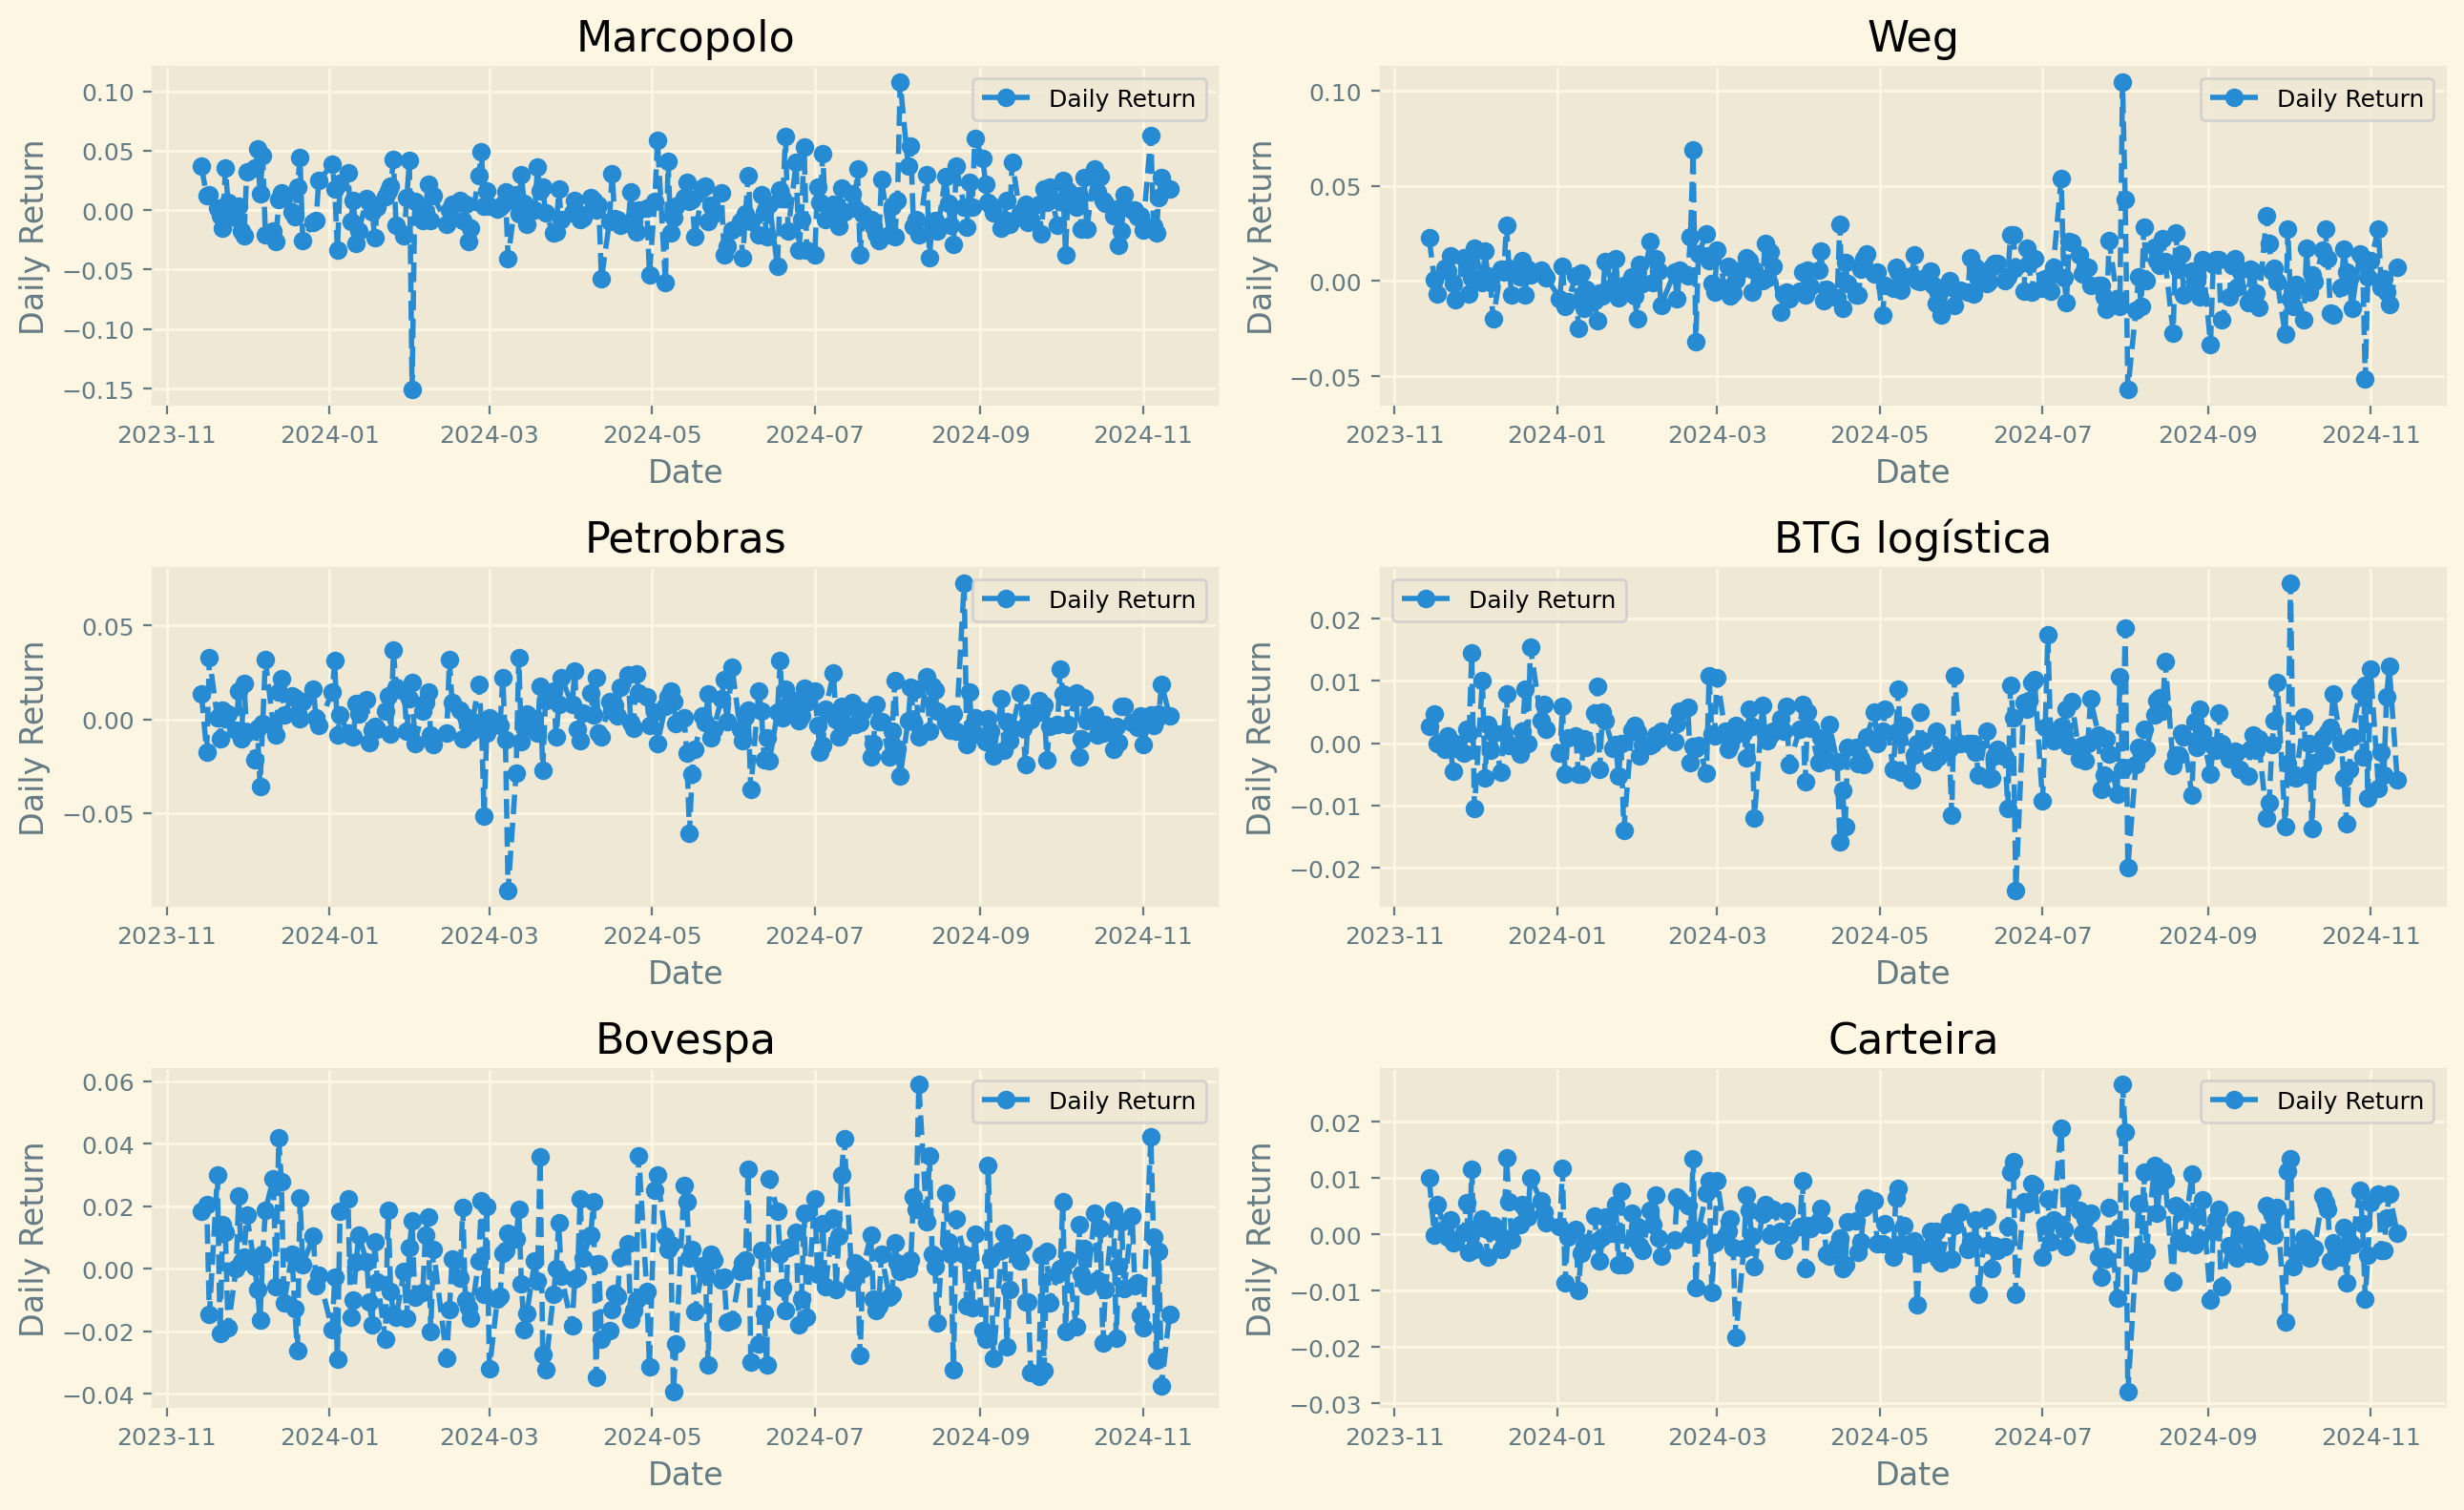

In [9]:
def calculate_and_plot_daily_returns(df_melted,  figsize=(13, 8)):
    """
    Function to calculate daily returns and plot them.

    Parameters:
    - df_melted (pd.DataFrame): Melted DataFrame containing 'Date', 'Company', and 'Price'.
    - company_name (list): List of company names.
    - figsize (tuple): Size of the figure (width, height).
    """
    # Add daily return columns for each company

    company_name = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa", "Carteira"]    
    for company in company_name:
        # Filter data for the specific company
        company_data = df_melted[df_melted['Company'] == company].copy()
        # Calculate the daily return
        company_data['Daily Return'] = company_data['Price'].pct_change()
        # Merge the daily return back into the original DataFrame
        df_melted.loc[df_melted['Company'] == company, 'Daily Return'] = company_data['Daily Return']

    # Set up subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=figsize)

    # Plot Daily Returns for each company
    for i, company in enumerate(company_name):
        ax = axes[i // 2, i % 2]  # Determine subplot position
        # Filter data for the current company
        company_data = df_melted[df_melted['Company'] == company]
        # Plot the daily returns
        ax.plot(company_data['Date'], company_data['Daily Return'], linestyle='--', marker='o', label='Daily Return')
        # Customize the plot
        ax.set_title(company)
        ax.set_ylabel('Daily Return')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True)

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()

calculate_and_plot_daily_returns(df_adj_close_melted)

### Taxa de Retorno Logarítmica

- Melhor para analisar ações da mesma empresa em períodos diferentes. 

In [10]:
def calculate_log_return(column, df):
    """
    Calculate and print the log return for a specific column in a DataFrame.
    
    Parameters:
    - column (str): The column name for which the log return is calculated.
    - df (pd.DataFrame): The DataFrame containing the stock prices.
    """
    initial_price = df[column].iloc[0]
    final_price = df[column].iloc[-1]
    log_return = round(np.log(final_price / initial_price), 4)
    print(f'Empresa: {column}, Retorno Log: {log_return}')

# Verificar se as colunas especificadas existem no DataFrame
columns_to_check = df_adj_close.columns[1:7]
missing_columns = [col for col in columns_to_check if col not in df_adj_close.columns]

if missing_columns:
    print(f"As seguintes colunas estão ausentes no DataFrame: {missing_columns}")
else:
    # Aplicar a função para as colunas selecionadas
    for column in columns_to_check:
        calculate_log_return(column, df_adj_close)

Empresa: Marcopolo, Retorno Log: 0.5271
Empresa: Weg, Retorno Log: 0.5465
Empresa: Petrobras, Retorno Log: 0.1808
Empresa: BTG logística, Retorno Log: 0.0686
Empresa: Bovespa, Retorno Log: -0.1684
Empresa: Carteira, Retorno Log: 0.2226


## Risco Médio Anual

- Maior a variabilidade, maior o risco

- O risco de um investimento está relacionado à incerteza do seu desempenho futuro, enquanto o retorno é o ganho financeiro que o investidor pode obter. A relação entre risco e retorno é um conceito central no mercado financeiro

- Utiliza-se o desvi-padrão

In [11]:
def calculate_annual_risk(df_melted):
    """
    Função para calcular o risco anual (desvio padrão anualizado do retorno diário) para cada empresa.

    Parâmetros:
    - df_melted (pd.DataFrame): DataFrame contendo 'Date', 'Company' e 'Price'.
    """
    company_name = ["Marcopolo", "Weg", "Petrobras", "BTG logística", "Bovespa", "Carteira"]

    for company in company_name:
        # Filtrar dados para a empresa específica
        company_data = df_melted[df_melted['Company'] == company].copy()
        # Calcular o retorno diário
        company_data['Daily Return'] = company_data['Price'].pct_change()
        # Calcular o risco anual como o desvio padrão do retorno diário 
        annual_risk = company_data['Daily Return'].std() * (len(company_data)**0.5)#anulização
        # Imprimir o risco anual formatado
        print(f'Empresa: {company}, Risco Anual: {round(annual_risk,3)}')

# Chame a função com o DataFrame apropriado
calculate_annual_risk(df_adj_close_melted)

Empresa: Marcopolo, Risco Anual: 0.401
Empresa: Weg, Risco Anual: 0.246
Empresa: Petrobras, Risco Anual: 0.252
Empresa: BTG logística, Risco Anual: 0.096
Empresa: Bovespa, Risco Anual: 0.274
Empresa: Carteira, Risco Anual: 0.097


### Risco de portifólio

In [12]:
def df_adj_close_corr():
    # Create a new DataFrame, excluding 'Date' and 'Carteira', without modifying df_adj_close
    df_cor = df_adj_close.drop(labels=['Date', 'Carteira'], axis=1, inplace=False)
    
    # Calculate the correlation matrix of df_cor
    correlation_matrix = df_cor.corr()
    
    # Return the correlation matrix
    return correlation_matrix

# Call the function to get and display the correlation matrix
df_adj_close_corr()


Price,Marcopolo,Weg,Petrobras,BTG logística,Bovespa
Price,,,,,
Marcopolo,1.000000,0.676933,0.297235,0.398628,-0.196701
Weg,0.676933,1.000000,0.548183,0.446263,-0.447563
Petrobras,0.297235,0.548183,1.000000,0.523317,-0.467181
BTG logística,0.398628,0.446263,0.523317,1.000000,-0.238156
Bovespa,-0.196701,-0.447563,-0.467181,-0.238156,1.000000


# Forecasting Tradicional

In [13]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_adj_close['Petrobras'])

(0.08719004989537305, True)

In [14]:
df_adj_close.set_index('Date', inplace=True)

train_size= int(0.8*len(df_adj_close))
train = df_adj_close['Petrobras'][:train_size]
test = df_adj_close['Petrobras'][-20:]

model = auto_arima(train,
                    start_p=0, max_p=5,      # Range of p values to search
                    start_q=0, max_q=5,      # Range of q values to search
                    d=None,                  # Automatically determine the value of d
                    seasonal=False,          # Set to True if you want to fit SARIMA
                    stepwise=True,           # Use stepwise algorithm for faster computation
                    trace=True, random_state = 16, n_fits=40)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=363.342, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=363.713, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=363.429, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=362.515, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=364.810, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.730 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -180.258
Date:                Tue, 12 Nov 2024   AIC                            362.515
Time:                        19:57:22   BIC                            365.814
Sample:                             0   HQIC                           363.850
                                - 201                                         
Co

In [15]:
# Forecast the next 10 steps
n_periods = 20
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# forecast_index = pd.date_range(df_adj_close.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
forecast_df = pd.DataFrame({'Lower CI': conf_int[:, 0], 'Upper CI': conf_int[:, 1]})

c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


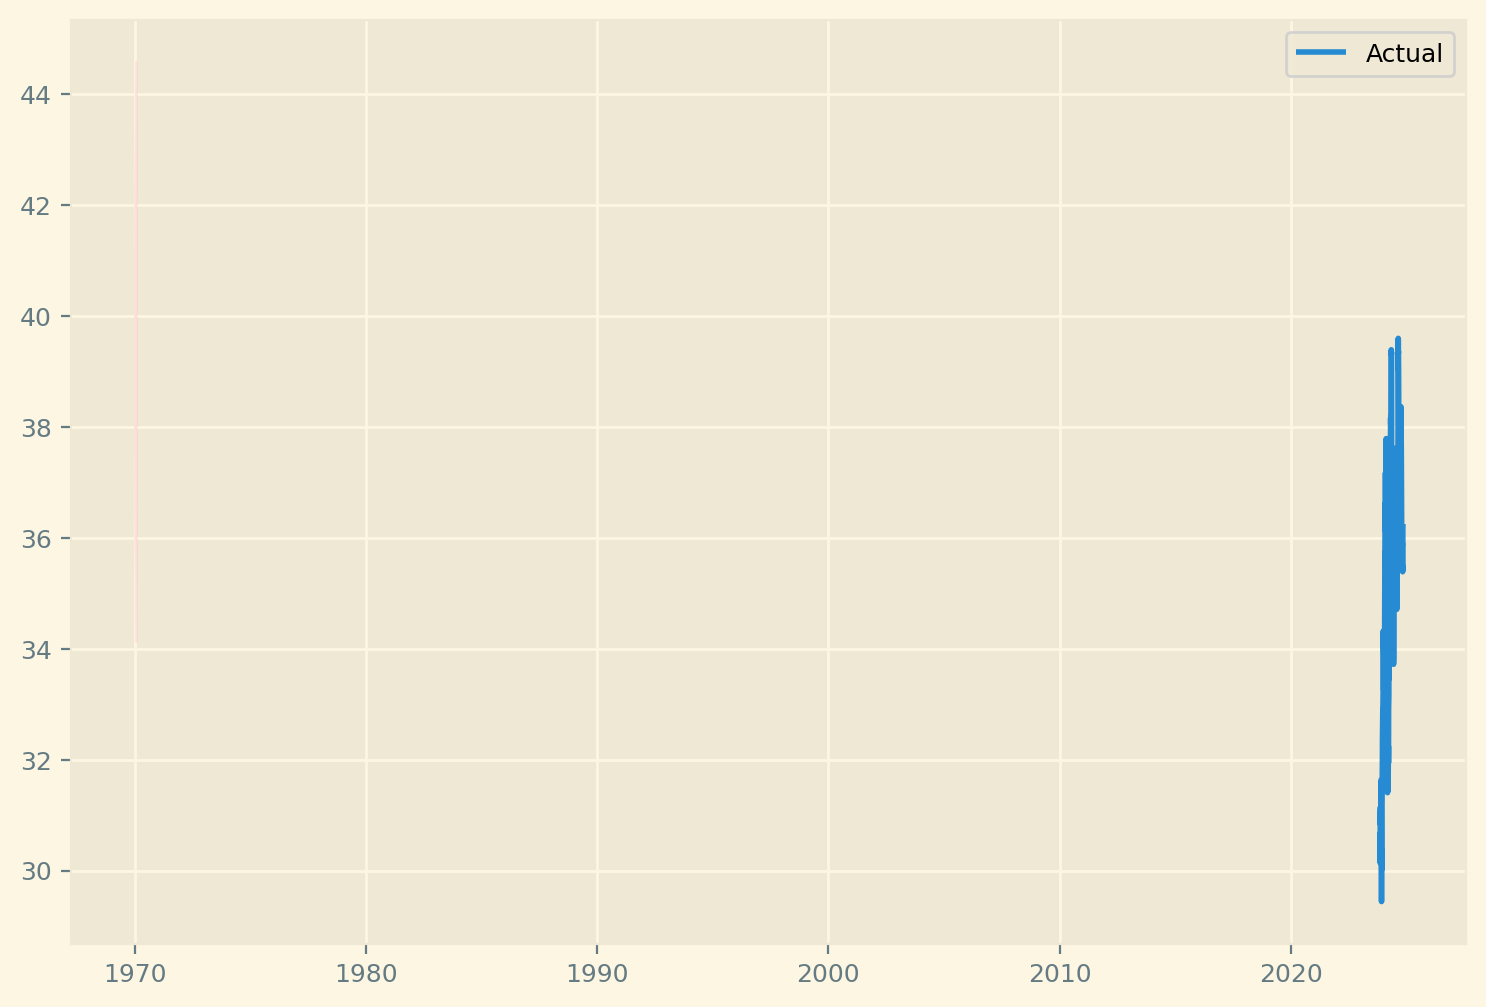

In [16]:
# Plotting
plt.figure(figsize=(9, 6))
plt.plot(df_adj_close['Petrobras'], label='Actual')
# plt.plot(forecast_df['Forecast'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.legend()

In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(df_adj_close['Petrobras'].values.reshape(-1,1))

def create_seq(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return torch.FloatTensor(sequences), torch.FloatTensor(labels)

seq_length = 10
X, y = create_seq(data_scaled, seq_length)

X_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class LSTM(nn.Module):
    def __init__(self,input_size = 1, hidden_layer_size = 50, output_size = 1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1, self.hidden_layer_size),
                            torch.zeros(1,1, self.hidden_layer_size))

    def forward(self, input_seq):
        # Initialize hidden state and cell state at the start of each forward pass
        batch_size = input_seq.shape[1] if len(input_seq.shape) > 1 else 1  # Handle single or batch input
        self.hidden_cell = (
            torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
            torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device)
        )

        # Reshape input to LSTM's expected input format: [seq_len, batch_size, input_size]
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), batch_size, -1), self.hidden_cell)

        # Pass the last output of the LSTM through the linear layer
        predictions = self.linear(lstm_out.view(len(input_seq), batch_size, -1)[-1])  # Get last time step's output
        
        return predictions

# Forescating - LSTM

In [18]:
model = LSTM() 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 100
for epoch in range(epochs):
    for seq, label in zip(X_train, y_train):
        optimizer.zero_grad()  # Reset gradients
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        ) 

        y_pred = model(seq)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()  # Perform backpropagation
        optimizer.step()  

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {single_loss.item()}')

print(f'Final Loss: {single_loss.item()}')

Epoch 0 Loss: 0.06094669923186302
Epoch 10 Loss: 0.003055710345506668
Epoch 20 Loss: 0.0007250244962051511
Epoch 30 Loss: 0.0006865569157525897
Epoch 40 Loss: 0.000609053298830986
Epoch 50 Loss: 0.00046098182792775333
Epoch 60 Loss: 0.0001777647266862914
Epoch 70 Loss: 0.0051907263696193695
Epoch 80 Loss: 0.0016515270108357072
Epoch 90 Loss: 0.00032817746978253126
Final Loss: 0.00045847948058508337


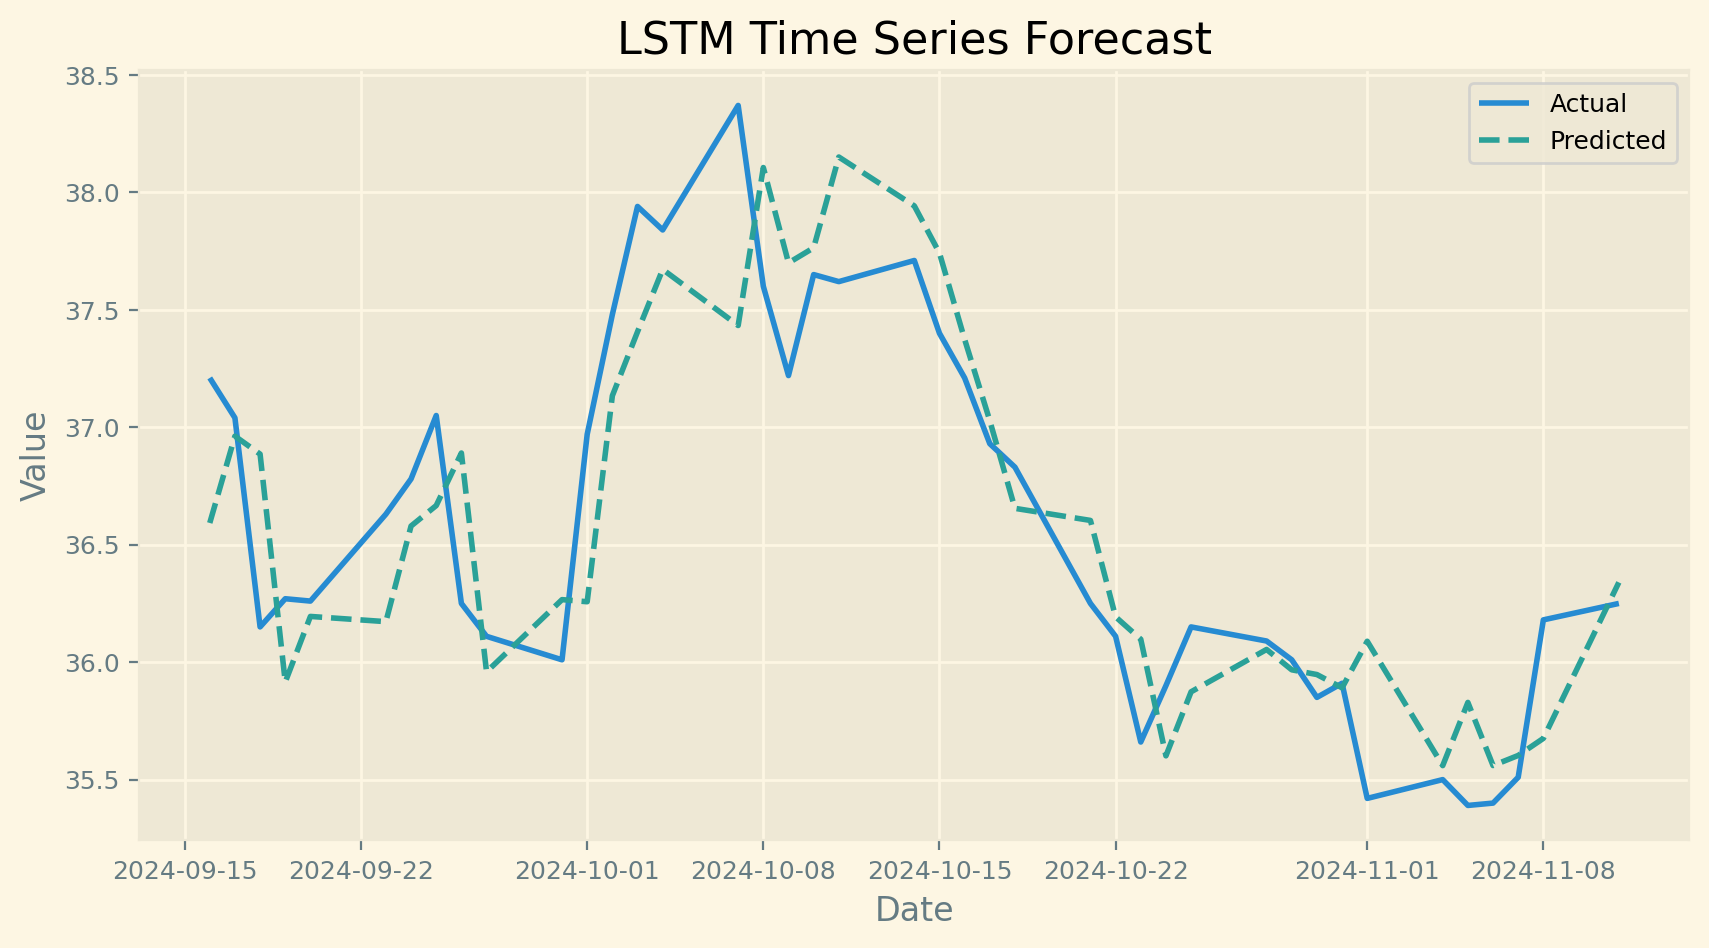

In [19]:
# Initialize an empty list to store predictions
predictions = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    for seq in x_test:
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        )
        predictions.append(model(seq).item())  # Get the scalar prediction and append to list

# Convert predictions and test labels back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,5))
plt.plot(df_adj_close.index[-len(y_test):], y_test, label='Actual')
plt.plot(df_adj_close.index[-len(predictions):], predictions, label='Predicted', linestyle='--')
plt.title('LSTM Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()